In [3]:
a=range(0,3)
a

range(0, 3)

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

In [2]:
dataset = read_csv("dataset_CBENS.csv",
                   infer_datetime_format=True, 
                   index_col= 0,
                   na_values=['nan','?'])
dataset.fillna(0, inplace=True)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
cols = list(dataset)[0:4]

In [3]:
dataset = dataset[cols].astype(float)

dataset.head(4)

,wnd_spd,wnd_spd_max,wnd_spd_min,u_star
TIMESTAMP,,,,
01-01-15 01,0.880716,0.880716,0.880716,0.054058
01-01-15 02,0.534274,0.679484,0.389064,0.035236
01-01-15 03,0.726290,0.774328,0.678251,0.038320
01-01-15 04,1.008452,1.107919,0.908986,0.061479


In [4]:

dataset


,wnd_spd,wnd_spd_max,wnd_spd_min,u_star
TIMESTAMP,,,,
01-01-15 01,0.880716,0.880716,0.880716,0.054058
01-01-15 02,0.534274,0.679484,0.389064,0.035236
01-01-15 03,0.726290,0.774328,0.678251,0.038320
01-01-15 04,1.008452,1.107919,0.908986,0.061479
01-01-15 05,1.019042,1.092352,0.945732,0.024612
...,...,...,...,...
31-12-15 19,1.301565,1.849679,0.753451,0.191664
31-12-15 20,1.950824,2.248115,1.653534,0.349691
31-12-15 21,0.802258,0.976875,0.627641,0.104242


In [5]:
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [6]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)

In [7]:
scaled.head(4)

,0,1,2,3
0,0.106174,0.093655,0.130784,0.020789
1,0.046140,0.062027,0.038702,0.011345
2,0.079414,0.076934,0.092864,0.012893
3,0.128308,0.129365,0.136079,0.024513


In [8]:
def create_ts_data(dataset, lookback=1, predicted_col=3):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["wnd_spd"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [9]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,3)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',]
print(reframed_df.head(4))


    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)
id                                                       
1    0.106174   0.093655   0.130784   0.020789   0.011345
2    0.046140   0.062027   0.038702   0.011345   0.012893
3    0.079414   0.076934   0.092864   0.012893   0.024513
4    0.128308   0.129365   0.136079   0.024513   0.006015


In [10]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.8)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

len(train)

6991

In [25]:
train_X

array([[[0.10617356, 0.09365533, 0.13078392, 0.0207891 ]],

       [[0.04614018, 0.06202725, 0.03870218, 0.01134514]],

       [[0.0794137 , 0.0769341 , 0.09286416, 0.01289252]],

       ...,

       [[0.12833285, 0.14104699, 0.12221126, 0.04801442]],

       [[0.13781226, 0.13039684, 0.15539327, 0.0458146 ]],

       [[0.11775832, 0.1267657 , 0.11637088, 0.03257607]]], dtype=float32)

In [11]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

test_X

(6991, 1, 4) (6991,) (1747, 1, 4) (1747,)


array([[[0.11223018, 0.12496026, 0.10657243, 0.02271606]],

       [[0.12569878, 0.1229417 , 0.13809204, 0.02446615]],

       [[0.11517732, 0.10194319, 0.14037079, 0.02284813]],

       ...,

       [[0.2916077 , 0.30857247, 0.27552524, 0.1691214 ]],

       [[0.09257798, 0.1087689 , 0.08338549, 0.04596841]],

       [[0.08358304, 0.07863975, 0.0998443 , 0.04883952]]], dtype=float32)

In [12]:
model_lstm = Sequential()
model_lstm.add(LSTM(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=30, return_sequences=True))
model_lstm.add(LSTM(units=30))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')

In [27]:
train_X.shape[1]

1

In [13]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 75)             24000     
                                                                 
 lstm_1 (LSTM)               (None, 1, 30)             12720     
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 44,071
Trainable params: 44,071
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit network
lstm_history = model_lstm.fit(train_X, train_y, epochs=30,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/30
110/110 [==============================] - 14s 40ms/step - loss: 0.0669 - val_loss: 0.0433
Epoch 2/30
110/110 [==============================] - 1s 12ms/step - loss: 0.0424 - val_loss: 0.0421
Epoch 3/30
110/110 [==============================] - 1s 11ms/step - loss: 0.0414 - val_loss: 0.0415
Epoch 4/30
110/110 [==============================] - 1s 11ms/step - loss: 0.0405 - val_loss: 0.0409
Epoch 5/30
110/110 [==============================] - 1s 11ms/step - loss: 0.0394 - val_loss: 0.0403
Epoch 6/30
110/110 [==============================] - 1s 11ms/step - loss: 0.0386 - val_loss: 0.0399
Epoch 7/30
110/110 [==============================] - 1s 10ms/step - loss: 0.0384 - val_loss: 0.0398
Epoch 8/30
110/110 [==============================] - 1s 9ms/step - loss: 0.0383 - val_loss: 0.0396
Epoch 9/30
110/110 [==============================] - 1s 10ms/step - loss: 0.0382 - val_loss: 0.0396
Epoch 10/30
110/110 [==============================] - 1s 10ms/step - loss: 0.0382 - val_lo

In [15]:
pred_y =  model_lstm.predict(test_X)


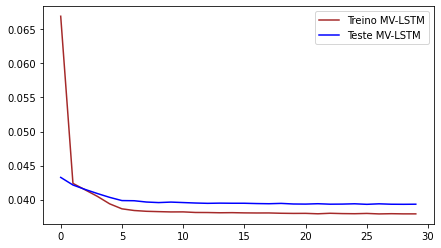

In [16]:
#dont run this cell if you are running this cell than add "validation_data=(test_X, test_y)" in model_gru.fit()
pyplot.figure(figsize=(7, 4))
pyplot.plot(lstm_history.history['loss'], label='Treino MV-LSTM', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='Teste MV-LSTM', color='blue')
pyplot.legend()
pyplot.savefig('loss.tiff', format='tiff')

pyplot.show()

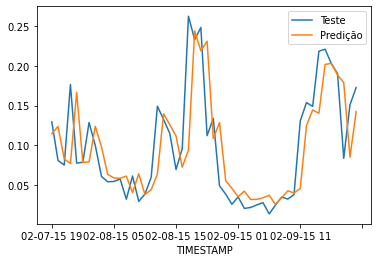

In [17]:
test_y.reshape(1747,1)

df = pd.DataFrame(test_y, columns=['Teste'])
df1 = pd.DataFrame(pred_y, columns=['Predição'])

df = pd.concat([df, df1], axis=1, join='inner')

df

plot_cols = ['Teste', 'Predição']
plot_features = df[plot_cols][450:500]
plot_features.index = dataset.index[450:500]
_ = plot_features.plot(subplots=False)



In [18]:
pred_y

array([[0.03227101],
       [0.03298525],
       [0.031465  ],
       ...,
       [0.15826103],
       [0.05269784],
       [0.05460881]], dtype=float32)

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)



0.0036516997
0.6147653493519927
0.0604292954596765
0.039319113


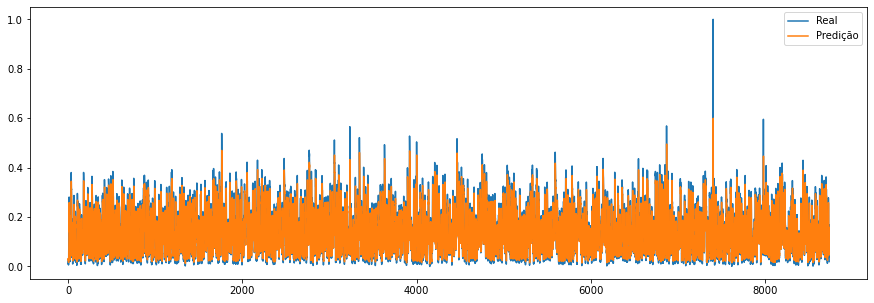

In [20]:
#visualization over full data
tra = np.concatenate([train_X,test_X])
tes = np.concatenate([train_y,test_y])
fp = model_lstm.predict(tra)
plt.plot(tes, label = 'Real')
plt.plot(fp, label = 'Predição')
plt.legend()
plt.show()

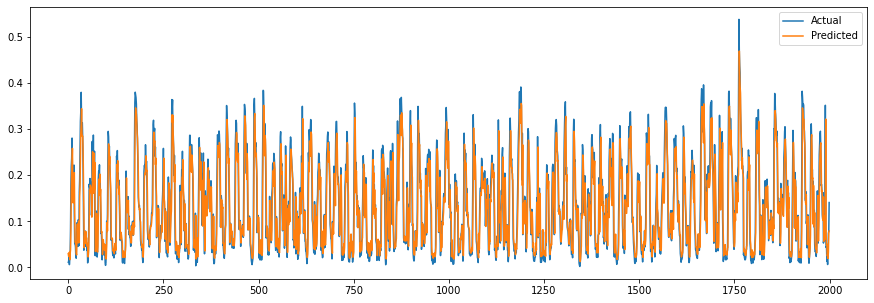

In [21]:
#over small part of data
plt.plot(tes[:2000], label = 'Actual')
plt.plot(fp[:2000], label = 'Predicted')
plt.legend()
plt.show()

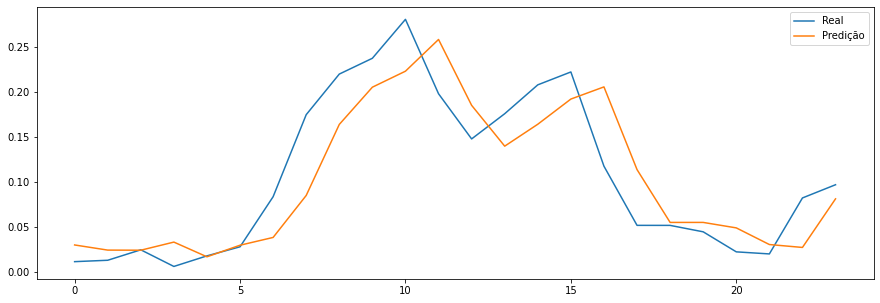

In [22]:
#over very small part of data
plt.plot(tes[:24], label = 'Real')
plt.plot(fp[:24], label = 'Predição')
plt.legend()
plt.show()

C:\Users\fanti\anaconda3\envs\older\lib\site-packages\numpy\lib\stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

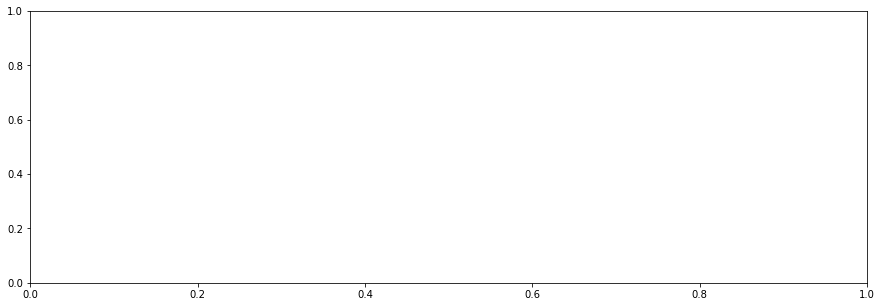

In [40]:
plt.bar(x = range(train_X.shape[2]),
        height=model_lstm.layers[0].get_weights())
axis = plt.gca()


In [42]:
model_lstm.layers[0].get_weights()

[array([[-0.02903784,  0.11930646, -0.01310995, ...,  0.1661125 ,
          0.04359695,  0.1784721 ],
        [-0.11935043,  0.06152321, -0.02104172, ...,  0.05310191,
          0.00725908,  0.15786579],
        [-0.02037692,  0.2524992 , -0.12578075, ...,  0.19228537,
          0.10252382, -0.00518016],
        [ 0.12074287, -0.11672732,  0.01186271, ...,  0.05988013,
          0.01844069,  0.20019515]], dtype=float32),
 array([[ 1.56741142e-02, -4.29640785e-02,  7.33086616e-02, ...,
         -2.63541322e-02, -1.42378239e-02, -4.99558263e-02],
        [ 7.33089074e-02,  1.23947859e-02, -1.11935705e-01, ...,
         -1.16556913e-01,  1.89510118e-02, -8.81844684e-02],
        [-2.48533823e-02,  4.04724218e-02,  8.67244005e-02, ...,
          1.12641323e-02, -1.30652755e-01, -5.68009447e-04],
        ...,
        [-7.86337629e-03, -3.24996747e-02, -8.73658434e-03, ...,
         -5.02060279e-02,  2.05812436e-02,  6.29945546e-02],
        [ 5.17690228e-03,  5.10551035e-05,  8.61525014e-02